<a href="https://colab.research.google.com/github/Nigeldm123/6DIST_lab2/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.2 Tasks

## 3.2.1 Getting Started

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Visualizing dataset


Image batch shape: torch.Size([4, 3, 32, 32])


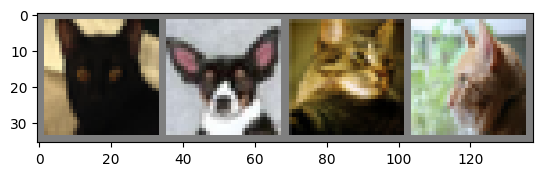

cat   dog   cat   cat  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print the size of the images
print(f"Image batch shape: {images.shape}")

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Designing the Convolutional layers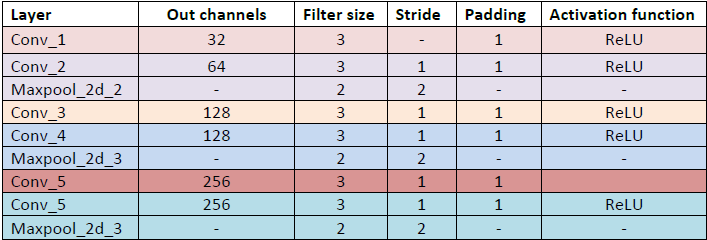

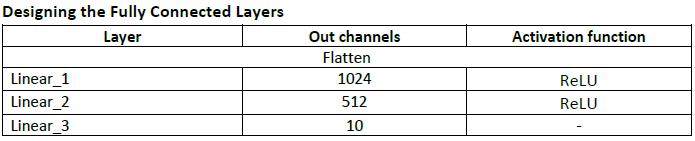

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers: Note initially 3 in channels because RGB image!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dummy input to determine output size after convolutions
        dummy_input = torch.randn(1, 3, 32, 32)  # Assuming input size is 32x32 RGB images
        n_channels = self.get_size(dummy_input)

        print(f'Number of features after flattening: {n_channels}')

        # Fully connected layers based on the structure
        self.fc1 = nn.Linear(n_channels, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)  # 10 classes for the output

    def get_size(self, x):
        # Forward pass through convolutional layers to get flattened size
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)  # First maxpool after conv2

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)  # Second maxpool after conv4

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)  # Third maxpool after conv6

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        return x.shape[1]  # Return the number of features

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max-pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)  # First maxpool after conv2

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)  # Second maxpool after conv4

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)  # Third maxpool after conv6

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))  # Linear_1: 1024 units + ReLU
        x = F.relu(self.fc2(x))  # Linear_2: 512 units + ReLU
        x = self.fc3(x)  # Linear_3: 10 units (output), no activation

        return x

# Instantiate the model
net = Net()


Number of features after flattening: 4096


## 3.2.2 Training preparation

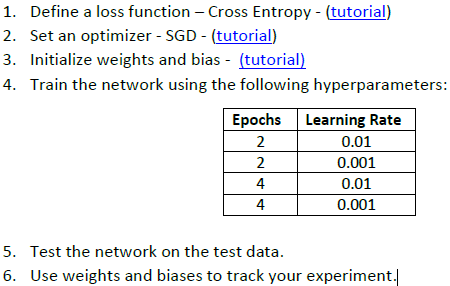

In [ ]:
import torch.optim as optim

LR = 0.01
num_epochs = 4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR)

In [ ]:
!pip install wandb -qU
# Log in to your W&B account
import wandb
import random
import math
import sklearn.metrics
import numpy

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="CNN",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"experiment_3_Epochs_{num_epochs}_LR_{LR}",
    # track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": num_epochs,
    }
)

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

            # 2️. Log metrics from your script to W&B
            wandb.log({"epoch": epoch, "running_loss": running_loss / 2000})

            running_loss = 0.0

print('Finished Training')
print('Initializing Testing')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    total_labels = numpy.array([])  # Ensure it's a NumPy array
    total_predicted = numpy.array([])  # Ensure it's a NumPy array
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append labels and predictions as NumPy arrays
        total_labels = numpy.append(total_labels, labels.numpy())
        total_predicted = numpy.append(total_predicted, predicted.numpy())

    print("numpy: ", total_labels)
    print("numpy: ", total_predicted)

    tensor_labels = torch.from_numpy(total_labels).long()  # Convert to long
    tensor_predicted = torch.from_numpy(total_predicted).long()  # Convert to long

    print("tensor: ", tensor_labels)
    print("tensor: ", tensor_predicted)

    test_accuracy = sklearn.metrics.accuracy_score(tensor_labels, tensor_predicted)
    F1_score = sklearn.metrics.f1_score(tensor_labels, tensor_predicted, average="weighted")
    recall = sklearn.metrics.recall_score(tensor_labels, tensor_predicted, average="weighted")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
wandb.log({"test_accuracy" : test_accuracy, "F1_score" : F1_score, "Recall" : recall})


# Mark the run as finished
wandb.finish()

CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [ ]:
PATH = './NN/cifar_net_exp3.pth'
torch.save(net.state_dict(), PATH)